# Constant Interval

We will choose a fixed parameter a > 0 for this strategy. In the beginning, we will provide liquidity in a symmetric interval around the current price. This interval will never be adjusted. More specifically, we will choose the interval [p − a, p + a], where p is the price at the beginning.
For the USDC-ETH pool, we will choose a ∈ [10, 40000], which means that the size is between 10 and 40000 basis points, or 0.1% and 400%. It does not make sense to choose another a because, at any time, the price is always in [p−a,p+a].

Import code dependencies

In [1]:
from typing import List

import pandas as pd
from matplotlib.pylab import plt
import matplotlib.dates as mdates
from datetime import date

from demeter import MarketInfo, Actuator, MarketInfo, TokenInfo, Strategy, ChainType
from demeter.broker import AccountStatus
from demeter.result import performance_metrics, round_results
from demeter.uniswap import UniV3Pool, UniLpMarket

pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

#Set matplotlib to show formatted account status
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

#Make plot about price and account value / position net value
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()

Custom Constant Interval strategy with code to add liquidity at constant interval around current price.

In [2]:
class ConstantIntervalStrategy(Strategy):
    def __init__(self, a=100):
        super().__init__()
        self.a = a

    def initialize(self):
        market: UniLpMarket = self.markets[market_key]
        init_price = market.market_status.data.price
        market.even_rebalance(init_price)  # rebalance all reserve token#
        # new_position(self, baseToken, quoteToken, usd_price_a, usd_price_b):
        # what is  base/quote "https://corporatefinanceinstitute.com/resources/knowledge/economics/currency-pair/"
        market.add_liquidity(init_price - self.a, init_price + self.a)
        super().__init__()

Main logic to run Actuator, init two token and market with key "market1"

In [3]:
from demeter.utils import pool_info as pi

I think that UniV3Pool could be made as general Pool class and then TokenInfo could be using it to initalize? 

In [4]:
API_KEY = "893d7471304c5edf436c8ba60781762c"
POOL_ADDRESS = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640".lower()
START_DATE = date(2024, 8, 1)
END_DATE = date(2024, 9, 1)

pool_info = pi.Pool(POOL_ADDRESS, API_KEY)
print(pool_info)


Pool Address: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
Token Pair: USDC/WETH
Decimals token1: 6
Decimals token2: 18
Fee Tier: 0.0005
Tick Spacing: 60
Current Tick: 198398
Current Sqrt Price: 1610043623318606251179396344339725
Liquidity: 9099898211323474113
Total Value Locked (USD): $405619381.60
Total Value Locked (ETH): 167650.233713 ETH
                


In [13]:
# usdc = TokenInfo(name=pool_info.token0, decimal=pool_info.decimals1)  # declare  token0
# eth = TokenInfo(name=pool_info.token1, decimal=pool_info.decimals1)  # declare token1
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, .05, usdc)  # declare pool
market_key = MarketInfo("market1")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

In [15]:
print(market)

{"type":"UniLpMarket","name":"market1","token0":{"name":"USDC","decimal":6,"address":""},"token1":{"name":"ETH","decimal":18,"address":""},"quote_token":{"name":"USDC","decimal":6,"address":""},"base_token":{"name":"ETH","decimal":18,"address":""},"fee_rate":"0.0005"}


In [6]:
broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = ConstantIntervalStrategy(100)

market.data_path = "../data"
market.load_data(ChainType.polygon.name, "0x45dda9cb7c25131df268515131f647d726f50608", date(2023, 8, 13),
                 date(2023, 8, 17))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2024-10-05 14:00:21,276 - INFO - start load files from 2023-08-13 to 2023-08-17...
2024-10-05 14:00:21,304 - INFO - load file complete, preparing...
2024-10-05 14:00:21,384 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [7]:
market.data.head(2)

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,price,low,high,volume0,volume1
2023-08-13 00:00:00,-1970524626,1066799650715290921,201101.0,201101.0,201101.0,201101.0,0,1066799650715290921,2391553663290390168,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,0,1.066799650715290921
2023-08-13 00:01:00,0,0,201101.0,201101.0,201101.0,201101.0,0,0,2391553663290390168,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,1848.1243777237890625289195435154359,0,0


In [8]:
actuator.run()

2024-10-05 14:00:24,663 - INFO - Qute token is USDC
2024-10-05 14:00:24,664 - INFO - init strategy...
2024-10-05 14:00:24,665 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 9383.41it/s]
2024-10-05 14:00:25,448 - INFO - main loop finished
2024-10-05 14:00:25,503 - INFO - Print actuator summary
2024-10-05 14:00:25,520 - INFO - Backtesting finished, execute time 0.8577699661254883s


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.026738035              
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1        liquidity
0      200570      201660  2.5731274  0.0017363770  843762970646576

Quote by: USDC
Account balance history                           
l1                  net_value tokens               market1                                                                                          price     
l2                              USDC         ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00 1999.5002      0 0.026738035  1950.085    1.8812218e-07                 0       0.51421585     

In [10]:
print({k: round(v, 5) for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})

# actuator.save_result(
#     path="./result",  # save path
#     account=True,  # save account status list as a csv file
#     actions=True,  # save actions as a json file and a pickle file
# )

TypeError: type Timestamp doesn't define __round__ method

In [11]:
print({k: round_results(v, 5) for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})

# actuator.save_result(
#     path="./result",  # save path
#     account=True,  # save account status list as a csv file
#     actions=True,  # save actions as a json file and a pickle file
# )

AttributeError: 'Timestamp' object has no attribute 'items'

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_74374/891681107.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


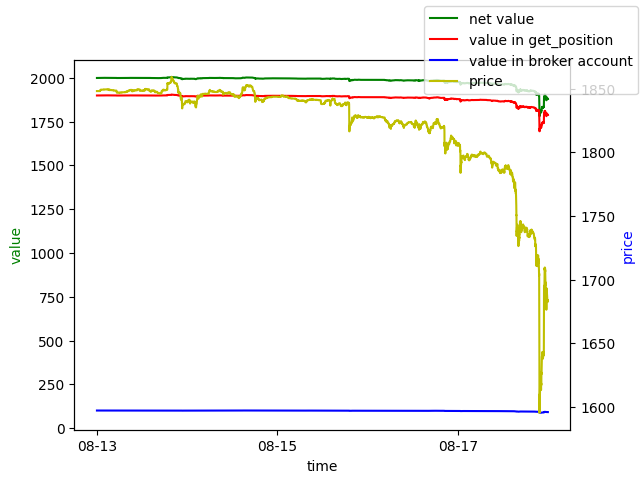

In [12]:
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)

### Let's try it with the newer Ethereum data 

In [13]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("market1")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = ConstantIntervalStrategy(200)

market.data_path = "/Users/gnapsamuel/Documents/AMM/demeter-fetch/sample-data"
market.load_data(ChainType.ethereum.name, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", date(2024, 7, 2),
                 date(2024, 8, 1))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2024-10-04 21:36:48,831 - INFO - start load files from 2024-07-02 to 2024-08-01...
2024-10-04 21:36:48,962 - INFO - load file complete, preparing...
2024-10-04 21:36:49,440 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [14]:
market.data.head()

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,price,low,high,volume0,volume1
2024-07-02 00:00:00,-59645838470,17345402519575340395,194886.0,194885.0,194885.0,194886.0,0,17345402519575340395,19604866381108097039,3440.9245402970851926409910188694417,3440.5804822488603066103299858708544,3440.9245402970851926409910188694417,3440.5804822488603066103299858708544,0,17.345402519575340395
2024-07-02 00:01:00,5902489506,-1713724919638445944,194886.0,194886.0,194886.0,194886.0,9761456799,1122266415802469747,19604866381108097039,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,9761.456799,1.122266415802469747
2024-07-02 00:02:00,-266698157080,77579135165690617297,194891.0,194887.0,194887.0,194891.0,1138500000,77909912233626236696,19564312406612336837,3440.2364586030000066096690189689593,3438.8607079744119766363274444637814,3440.2364586030000066096690189689593,3438.8607079744119766363274444637814,1138.5,77.909912233626236696
2024-07-02 00:03:00,397928385,-115332650372234652,194891.0,194891.0,194891.0,194891.0,1533457345,330386568300773025,19564312406612336837,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1533.457345,0.330386568300773025
2024-07-02 00:04:00,-1257981760,366337156837051095,194891.0,194891.0,194891.0,194891.0,1108817933,688628792423050930,19564312406612336837,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1108.817933,0.68862879242305093


In [15]:
actuator.run()

2024-10-04 21:36:51,203 - INFO - Qute token is USDC
2024-10-04 21:36:51,204 - INFO - init strategy...
2024-10-04 21:36:51,206 - INFO - start main loop...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [00:05<00:00, 8803.70it/s]
2024-10-04 21:36:56,278 - INFO - main loop finished
2024-10-04 21:36:56,721 - INFO - Print actuator summary
2024-10-04 21:36:56,822 - INFO - Backtesting finished, execute time 5.620736122131348s


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.013504318              
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0     pending1        liquidity
0      194320      195480  39.908089  0.012149612  582470219044557

Quote by: USDC
Account balance history                           
l1                  net_value tokens               market1                                                                                          price     
l2                              USDC         ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2024-07-02 00:00:00 1999.5008      0 0.013504318 1953.0381    2.5766256e-07                 0       0.27707167       

In [20]:
print({k: round(v, 5) for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})

TypeError: type Timestamp doesn't define __round__ method

In [21]:
print({k: v for k, v in round_results(performance_metrics(
    actuator.account_status_df["net_value"], 
    benchmark=actuator.account_status_df["price"]["ETH"]
)).items()})


{Start period: Timestamp('2024-07-02 00:00:00'), End period: Timestamp('2024-08-01 23:59:00'), Duration: Timedelta('31 days 00:00:00'), Return: -31.27758, Rate of Return: -0.01564, APR: -0.16942, Max Draw Down: 0.17457, Sharpe Ratio: -0.41957, Volatility: 0.4753, Alpha: 0.32842, Beta: 0.87406, Benchmark return rate: -0.06909, Benchmark APR: -0.56958}


In [ ]:



actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)

2024-10-04 19:58:46,469 - INFO - Qute token is USDC
2024-10-04 19:58:46,470 - INFO - init strategy...
2024-10-04 19:58:46,472 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 9511.93it/s]
2024-10-04 19:58:47,312 - INFO - main loop finished
2024-10-04 19:58:47,395 - INFO - Print actuator summary
2024-10-04 19:58:47,413 - INFO - Backtesting finished, execute time 0.9456310272216797s


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.054134077              
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1        liquidity
0      200070      202250  3.0099089  0.0019814629  416554837570579

Quote by: USDC
Account balance history                           
l1                  net_value tokens               market1                                                                                          price     
l2                              USDC         ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00    1999.5      0 0.054134077 1899.4535    9.2890069e-08                 0       0.48681981     

TypeError: type Timestamp doesn't define __round__ method

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_71086/242916292.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


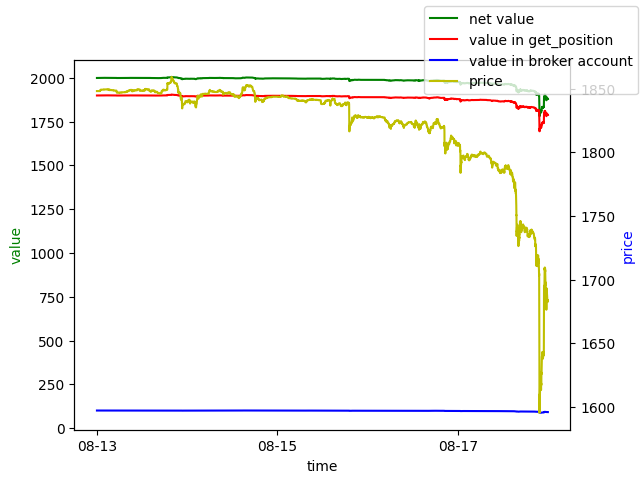

In [ ]:
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)